In [ ]:
# ==========================================
# 0. Install packages
# ==========================================
# %pip install yfinance xgboost tensorflow scikit-learn fastapi uvicorn

In [4]:
# ==========================================
# 1. ENVIRONMENT SETUP & IMPORTS
# ==========================================
import os
import time
import math
import joblib
import warnings
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

# Deep Learning (TensorFlow/Keras)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Plotting Style
plt.style.use('fivethirtyeight')
sns.set_palette("viridis")
warnings.filterwarnings('ignore')

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

print("Environment Setup Complete. TensorFlow Version:", tf.__version__)

Environment Setup Complete. TensorFlow Version: 2.20.0


In [5]:
# ==========================================
# 2. CONFIGURATION
# ==========================================
class Config:
    TICKER = "AAPL"        # Target Company
    START_DATE = "2015-01-01"
    END_DATE = "2024-01-01" # Or datetime.now()
    PREDICTION_DAYS = 1    # Forecasting horizon (N days ahead)
    LOOKBACK = 60          # For LSTM (Timesteps)
    TEST_SIZE = 0.2        # 20% for testing
    MODEL_DIR = "./models"
    DATA_DIR = "./data"

    # Hyperparameters for XGBoost
    XGB_PARAMS = {
        'n_estimators': 1000,
        'learning_rate': 0.01,
        'max_depth': 5,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'early_stopping_rounds': 50,
        'random_state': RANDOM_SEED
    }

# Create Directories
os.makedirs(Config.MODEL_DIR, exist_ok=True)
os.makedirs(Config.DATA_DIR, exist_ok=True)

In [6]:
# ==========================================
# 3. DATA COLLECTION
# ==========================================
class DataLoader:
    """
    Handles data fetching from APIs and local caching.
    """
    def __init__(self, ticker, start_date, end_date, data_dir):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.data_dir = data_dir
        self.file_path = os.path.join(data_dir, f"{ticker}_{start_date}_{end_date}.csv")

    def fetch_data(self):
        """Fetches data from yfinance or loads from cache."""
        if os.path.exists(self.file_path):
            print(f"[INFO] Loading cached data for {self.ticker}...")
            df = pd.read_csv(self.file_path, index_col='Date', parse_dates=True)
        else:
            print(f"[INFO] Fetching data from API for {self.ticker}...")
            try:
                df = yf.download(self.ticker, start=self.start_date, end=self.end_date, progress=False)
                if df.empty:
                    raise ValueError("No data found for ticker.")
                
                # Handling multi-level columns if any (yfinance update)
                if isinstance(df.columns, pd.MultiIndex):
                    df.columns = df.columns.get_level_values(0)
                
                df.to_csv(self.file_path)
            except Exception as e:
                print(f"[ERROR] Failed to fetch data: {e}")
                return None
        
        return df

# Usage
loader = DataLoader(Config.TICKER, Config.START_DATE, Config.END_DATE, Config.DATA_DIR)
raw_df = loader.fetch_data()
raw_df.head()

[INFO] Fetching data from API for AAPL...


Price,Close,High,Low,Open,Volume
Date,,,,,
2015-01-02,24.214897,24.682230,23.776357,24.671155,212818400
2015-01-05,23.532713,24.064276,23.346667,23.984541,257142000
2015-01-06,23.534935,23.794071,23.173914,23.596950,263188400
2015-01-07,23.864948,23.964616,23.632389,23.743131,160423600
2015-01-08,24.781897,24.839483,24.075361,24.192749,237458000


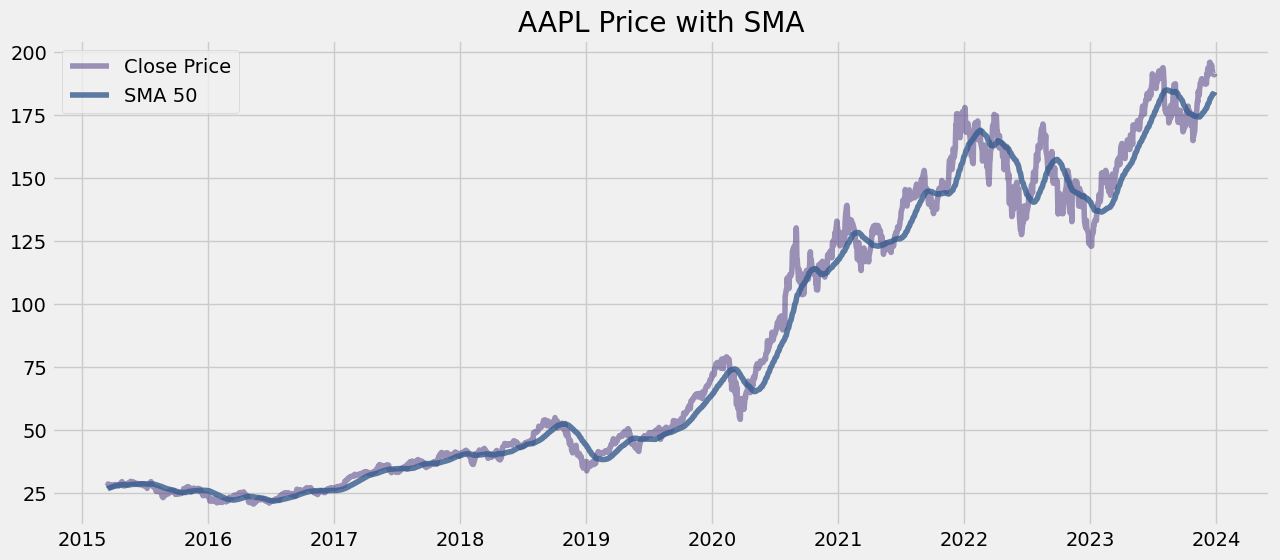

In [8]:
# ==========================================
# 4. FEATURE ENGINEERING
# ==========================================
class FeatureEngineer:
    """
    Generates technical indicators and prepares features.
    """
    def __init__(self, df):
        self.df = df.copy()

    def add_technical_indicators(self):
        df = self.df
        
        # 1. Moving Averages
        df['SMA_20'] = df['Close'].rolling(window=20).mean()
        df['SMA_50'] = df['Close'].rolling(window=50).mean()
        df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
        df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()

        # 2. MACD
        df['MACD'] = df['EMA_12'] - df['EMA_26']
        df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

        # 3. RSI (Relative Strength Index)
        delta = df['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        df['RSI'] = 100 - (100 / (1 + rs))

        # 4. Bollinger Bands
        df['BB_Middle'] = df['Close'].rolling(window=20).mean()
        df['BB_Upper'] = df['BB_Middle'] + (df['Close'].rolling(window=20).std() * 2)
        df['BB_Lower'] = df['BB_Middle'] - (df['Close'].rolling(window=20).std() * 2)

        # 5. Lag Features (Autocorrelation)
        for lag in [1, 2, 3, 5]:
            df[f'Lag_{lag}'] = df['Close'].shift(lag)

        # 6. Daily Returns & Volatility
        df['Daily_Return'] = df['Close'].pct_change()
        df['Volatility'] = df['Daily_Return'].rolling(window=21).std()

        # Target Variable: Next N Day Close
        df['Target'] = df['Close'].shift(-Config.PREDICTION_DAYS)

        # Cleanup
        df.dropna(inplace=True)
        self.df = df
        return df

    def get_features_labels(self):
        """Splits X and y."""
        features = [col for col in self.df.columns if col not in ['Target', 'Date']]
        X = self.df[features]
        y = self.df['Target']
        return X, y

# Apply Engineering
engineer = FeatureEngineer(raw_df)
processed_df = engineer.add_technical_indicators()

# Visualization of Indicators
plt.figure(figsize=(14, 6))
plt.plot(processed_df.index, processed_df['Close'], label='Close Price', alpha=0.5)
plt.plot(processed_df.index, processed_df['SMA_50'], label='SMA 50', alpha=0.8)
plt.title(f"{Config.TICKER} Price with SMA")
plt.legend()
plt.show()

In [9]:
# ==========================================
# 5. PREPROCESSING & SPLIT
# ==========================================
X, y = engineer.get_features_labels()

# Time-Series Split (No random shuffle!)
split_idx = int(len(X) * (1 - Config.TEST_SIZE))

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save scaler for production
joblib.dump(scaler, os.path.join(Config.MODEL_DIR, "scaler.pkl"))

print(f"Training Samples: {X_train.shape[0]} | Testing Samples: {X_test.shape[0]}")

Training Samples: 1771 | Testing Samples: 443


In [10]:
# ==========================================
# 6. MODEL 1: XGBOOST REGRESSOR
# ==========================================
print("Training XGBoost...")

xgb_model = XGBRegressor(**Config.XGB_PARAMS)

# Fit model
xgb_model.fit(
    X_train_scaled, 
    y_train,
    eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)],
    verbose=False
)

# Predictions
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Metrics
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
print(f"XGBoost RMSE: {rmse_xgb:.4f}")
print(f"XGBoost MAE: {mae_xgb:.4f}")

# Save Model
joblib.dump(xgb_model, os.path.join(Config.MODEL_DIR, "xgb_model.pkl"))

Training XGBoost...
XGBoost RMSE: 8.9245
XGBoost MAE: 6.0205


['./models\\xgb_model.pkl']

In [ ]:
# ==========================================
# 7. MODEL 2: LSTM (DEEP LEARNING)
# ==========================================
# LSTM requires 3D Input: [Samples, Time Steps, Features]

def create_sequences(X_data, y_data, lookback):
    X_seq, y_seq = [], []
    for i in range(len(X_data) - lookback):
        X_seq.append(X_data[i:(i + lookback)])
        y_seq.append(y_data[i + lookback])
    return np.array(X_seq), np.array(y_seq)

# Prepare Data for LSTM
# Note: For simplicity here, we use the scaled features from before
X_train_lstm, y_train_lstm = create_sequences(X_train_scaled, y_train.values, Config.LOOKBACK)
X_test_lstm, y_test_lstm = create_sequences(X_test_scaled, y_test.values, Config.LOOKBACK)

print(f"LSTM Input Shape: {X_train_lstm.shape}")

# Build Model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(Config.LOOKBACK, X_train_lstm.shape[2])))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=50, return_sequences=False))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=25))
model_lstm.add(Dense(units=1)) # Prediction of next close price

model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Train
history = model_lstm.fit(
    X_train_lstm, y_train_lstm,
    batch_size=32,
    epochs=20, # Increase for production
    validation_data=(X_test_lstm, y_test_lstm),
    verbose=1
)

# Predict
y_pred_lstm = model_lstm.predict(X_test_lstm)

# Evaluation (Trim y_test to match LSTM sequence loss)
y_test_trimmed = y_test.values[Config.LOOKBACK:]
rmse_lstm = np.sqrt(mean_squared_error(y_test_trimmed, y_pred_lstm))
print(f"LSTM RMSE: {rmse_lstm:.4f}")

# Save Keras Model
model_lstm.save(os.path.join(Config.MODEL_DIR, "lstm_model.h5"))

LSTM Input Shape: (1711, 60, 21)
Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 4552.2896 - val_loss: 17661.9414
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 2444.4531 - val_loss: 11620.1562
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 1972.3406 - val_loss: 10003.4502
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 1961.9045 - val_loss: 9987.3262
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 1956.0752 - val_loss: 10190.4463
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 1550.8831 - val_loss: 6989.3892
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 481.0046 - val_loss: 2431.0283
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 159.3415 - val_loss: 1222.9335
Epoch 9/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 103.9430 - val_loss: 791.2020
Epoch 10/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 70.4081 - val_loss: 563.8558
Epoch 11/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss:

LSTM RMSE: 14.0593


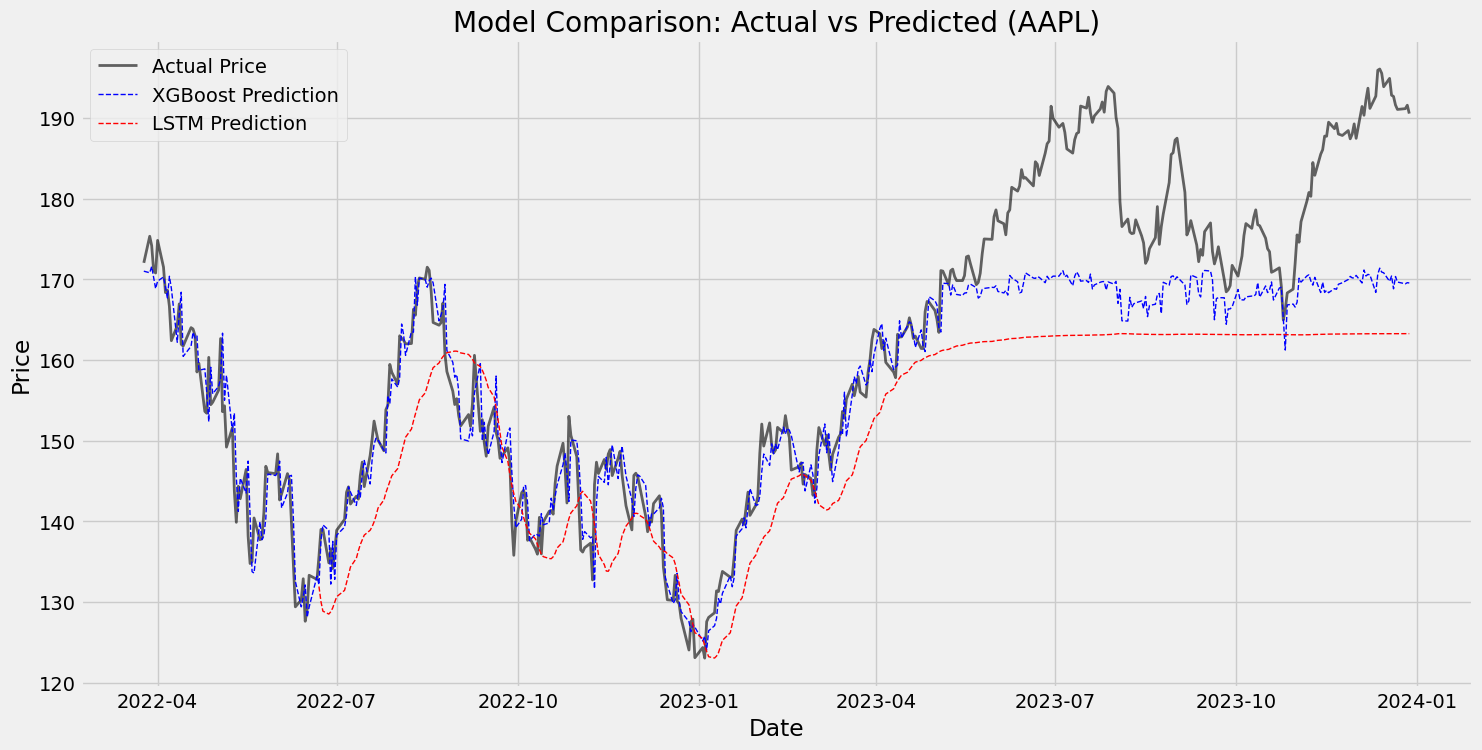

XGBoost Directional Accuracy: 50.90%


In [12]:
# ==========================================
# 8. EVALUATION & PLOTTING
# ==========================================

# Aligning indices for plotting
xgb_indices = y_test.index
lstm_indices = y_test.index[Config.LOOKBACK:]

plt.figure(figsize=(16, 8))

# Plot Actual
plt.plot(xgb_indices, y_test, label="Actual Price", color='black', alpha=0.6, linewidth=2)

# Plot XGBoost
plt.plot(xgb_indices, y_pred_xgb, label="XGBoost Prediction", color='blue', linestyle='--', linewidth=1)

# Plot LSTM
plt.plot(lstm_indices, y_pred_lstm, label="LSTM Prediction", color='red', linestyle='--', linewidth=1)

plt.title(f"Model Comparison: Actual vs Predicted ({Config.TICKER})")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

# Directional Accuracy (For XGBoost)
# Did the model correctly predict Up/Down movement?
actual_diff = np.diff(y_test)
pred_diff = np.diff(y_pred_xgb)
# Sign match?
correct_direction = np.sign(actual_diff) == np.sign(pred_diff)
da = np.mean(correct_direction) * 100
print(f"XGBoost Directional Accuracy: {da:.2f}%")

<Figure size 1000x800 with 0 Axes>

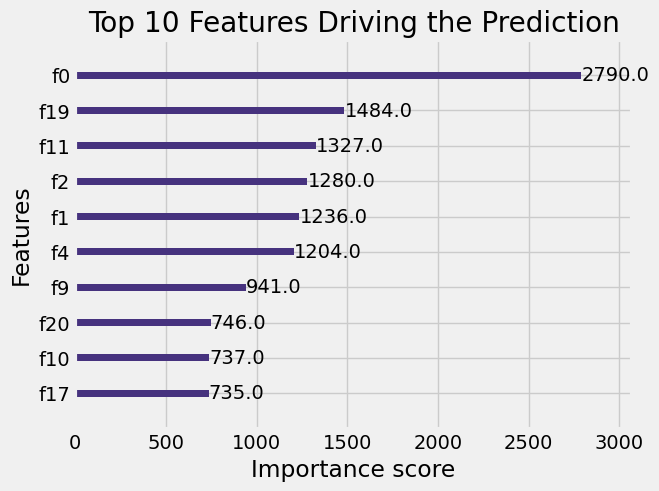

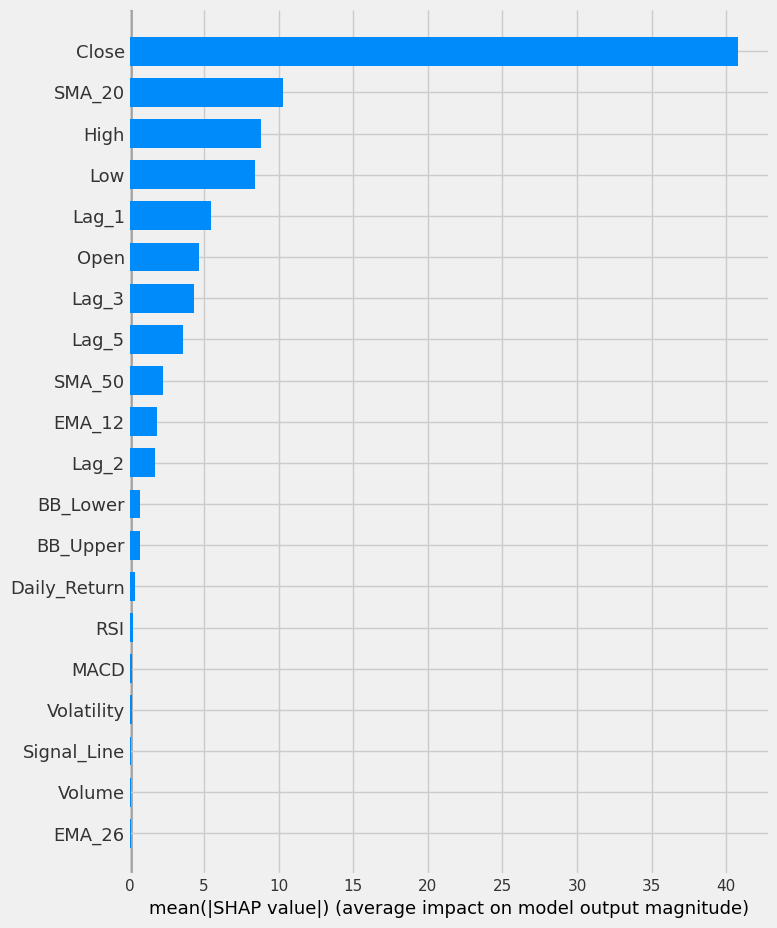

In [14]:
# ==========================================
# 9. FEATURE IMPORTANCE (XGBoost)
# ==========================================
import xgboost as xgb

plt.figure(figsize=(10, 8))
xgb.plot_importance(xgb_model, max_num_features=10, importance_type='weight')
plt.title("Top 10 Features Driving the Prediction")
plt.show()

# SHAP Analysis (Optional but recommended for Deep Dives)
import shap
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_scaled)
shap.summary_plot(shap_values, X_test, plot_type="bar")